<a href="https://colab.research.google.com/github/Estocastic/Hello-world/blob/master/COD_BPN_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
directorio = '/content/drive/My Drive/Datos_BPN2023'

# CAPITULO 1. PREPROCESAMIENTO NACIMIENTOS

## 1.1. CARGA DE LOS DATOS NACIMIENTOS Y FILTROS LIMITROFES

### 1.1. CARGA INICIAL DE NACIMIENTOS Y MORTALIDAD EN LA CIUDAD DE CALI



#### CALI

In [ ]:
# Lista para almacenar los DataFrames de Excel
dfs = []

# Cargar los data frames de nacimientos
anyo_ini=2011
for filename in os.listdir(directorio):
    if filename.startswith("NACIM") and filename.endswith(('xls', 'xlsx')):  # Filtrar si el archivo es de nacimiento

        df = pd.read_excel(os.path.join(directorio, filename))
        df['anyo']=anyo_ini
        print(filename)
        dfs.append(df)
        anyo_ini=anyo_ini+1

In [ ]:
pd.DataFrame(list(map(lambda x: x.columns, dfs))).T # la variable fecha ultima modificacion no estan en la base 2017

In [ ]:
dfs=list(map(lambda x: x.drop('Fecha Última Modificación', axis=1, errors='ignore'), dfs)) # se retira la variable

In [ ]:
df_final = pd.concat(dfs, ignore_index=True)

#### VALLE

In [ ]:
nac_valle = pd.read_excel('/content/drive/My Drive/Datos_BPN2023/BD_Nv_2011_2021_HABC_v2.xlsx')

#### FILTROS LIMITROFES: SE DESCARTAN NACIMIENTOS FUERA DEL VALLE

In [ ]:
# Identificamos filtros: Nacimientos solo cuyo departamento de residencia fuese el valle.
(df_final['Departamento Residencia'] == 'VALLE DEL CAUCA').value_counts()

True     377416
False     24862
Name: Departamento Residencia, dtype: int64

In [ ]:
# Identificamos filtros: Nacimientos solo cuyo departamento de residencia fuese el valle.
(nac_valle['CODPTORE'] == 76).value_counts()

True    265838
Name: CODPTORE, dtype: int64

In [ ]:
f_valle_dptres = df_final['Departamento Residencia'] == 'VALLE DEL CAUCA'

In [ ]:
df_final = df_final[f_valle_dptres].copy()

## 1.2. APLICACIÓN DE FILTROS PARA LLEGAR A LA POBLACIÓN OBJETIVO:

### 2.1. Construcción de los filtros



In [ ]:
print('Médidas iniciales del Tiempo gestación y el Peso al nacer: \n')
print(f'CALI \n',df_final[['Tiempo Gestación','Peso']].describe().round())
print(f'VALLE \n',nac_valle[['T_GES','PESO_NAC']].describe().round())

Médidas iniciales del Tiempo gestación y el Peso al nacer: 

CALI 
        Tiempo Gestación      Peso
count          377343.0  377412.0
mean               38.0    3126.0
std                 2.0     556.0
min                18.0     220.0
25%                38.0    2860.0
50%                39.0    3180.0
75%                40.0    3480.0
max                49.0    5960.0
VALLE 
           T_GES  PESO_NAC
count  265838.0  265838.0
mean       39.0    3147.0
std         3.0     549.0
min        15.0     208.0
25%        38.0    2880.0
50%        39.0    3180.0
75%        40.0    3490.0
max        99.0    9999.0


In [ ]:
f_bpnt_cali = ((df_final['Peso'] < 2500) & (df_final['Tiempo Gestación'] >= 37))
conteo = f_bpnt_cali.sum()
porcentaje = (conteo / len(df_final)) * 100

print(((df_final['Peso'] < 2500 ) & (df_final['Tiempo Gestación'] >= 37)).value_counts())
print(f'Número de nacidos vivos en Cali con BPNT: {conteo}')
print(f'Porcentaje de nacidos vivos en el Valle con BPNT: {porcentaje:.2f}%')


False    365640
True      11776
dtype: int64
Número de nacidos vivos en Cali con BPNT: 11776
Porcentaje de nacidos vivos en el Valle con BPNT: 3.12%


In [ ]:
f_bpnt_valle = ((nac_valle['PESO_NAC'] < 2500 ) & (nac_valle['T_GES'] >= 37))
conteo = f_bpnt_valle.sum()
porcentaje = (conteo / len(df_final)) * 100

print(((nac_valle['PESO_NAC'] < 2500 ) & (nac_valle['T_GES'] >= 37)).value_counts())
print(f'Número de nacidos vivos en Cali con BPNT: {conteo}')
print(f'Porcentaje de nacidos vivos en el Valle con BPNT: {porcentaje:.2f}%')


False    258117
True       7721
dtype: int64
Número de nacidos vivos en Cali con BPNT: 7721
Porcentaje de nacidos vivos en el Valle con BPNT: 2.05%


### 2.2. Aplicación de los filtros: POBLACIÓN OBJETIVO

In [ ]:
nac_cali = df_final[f_bpnt_cali].copy()
nac_valle = nac_valle[f_bpnt_valle].copy()

print(nac_cali.shape)
print(nac_valle.shape)

(11776, 51)
(7721, 45)


#### 2.2.1. PLUS: eliminar nacimientos fuera del valle

Conclusión: En total se tienen 11.776 + 7721 = 19.497
 registros de nacimientos con BPNT sumados en las dos fuentes de datos. Sin embargo, antes de unirlos falta corroborar y descartar de una de las bases registros con cédulas que estén contenidos en ambos y que correspondan al mismo nacimiento (fecha de nacimiento).

### 2.3. ADICIONAL:  Recategorización de las variables y Se lección de Columnas

Se recategorizan las variables del Valle del cauca con base en los valores asociados en df_mapeo que relaciona número y nombre, según el formulario de nacimientos RUAF.

Las de Cali no necesitan recategorización.

In [ ]:
df_mapeo = pd.read_excel('/content/drive/My Drive/Datos_BPN2023/variables_codificar.xlsx')

In [ ]:
mapeo_dict = {}
for columna in df_mapeo['name'].unique():
    sub_df = df_mapeo[df_mapeo['name'] == columna].copy()
    mapeo_dict[columna] = dict(zip(sub_df['numero'], sub_df['categoria']))
for columna, mapeo in mapeo_dict.items():
    nac_valle.loc[:,columna] = nac_valle.loc[:,columna].map(mapeo)

#### Se seleccionan ***`parcialmente`*** las variables de interés colocandoseles el mismo nombre para su posterior unión. Se mantienen los nombres de las columnas del conjunto de datos de Cali

In [ ]:
nac_cali = nac_cali[['Municipio Nacimiento' , 'Area Nacimiento' , 'Sitio Parto' , 'IPS' , 'Sexo' , 'Peso' , 'Talla' , 'Fecha Nacimiento' , 'Parto Atendido Por' , 'Tiempo Gestación' , 'Número Consultas Prenatales' , 'Tipo Parto' , 'Multiplicidad Embarazo' , 'APGAR1' , 'APGAR5' , 'Grupo Sanguineo' , 'Factor RH' , 'Pertenencia Étnica' , 'Pueblo Indígena' , 'Tipo Documento Madre' , 'Numero Documento Madre' , 'Edad Madre' , 'Estado Conyugal Madre' , 'Último Año Estudios Madre' , 'Municipio Residencia' , 'Área Residencia' , 'Número Hijos Nacidos Vivos' , 'Fecha Nacimiento Anterior Hijo' , 'Numero Embarazos' , 'Régimen Seguridad Social' , 'EPS' , 'Edad Padre' , 'Último Año Estudios Padre']]

In [ ]:
nac_valle=nac_valle[['COD_MUNIC' , 'AREANAC' , 'SIT_PARTO' , 'NOM_INST' , 'SEXO' , 'PESO_NAC' , 'TALLA_NAC' , 'FECHA_NAC' , 'ATEN_PAR' , 'T_GES' , 'NUMCONSUL' , 'TIPO_PARTO' , 'MUL_PARTO' , 'APGAR1' , 'APGAR2' , 'IDHEMOCLAS' , 'IDFACTORRH' , 'IDPERTET' , 'NOM_PUEB' , 'DOC_ID' , 'NRO_DOC' , 'EDAD_MADRE' , 'EST_CIVM' , 'NIV_EDUM' , 'CODMUNRE' , 'AREA_RES' , 'N_HIJOSV' , 'FECHA_NACM' , 'N_EMB' , 'SEG_SOCIAL' , 'NOMCLASAD' , 'EDAD_PADRE' , 'NIV_EDUP']]

In [ ]:
nac_valle.columns = ['Municipio Nacimiento' , 'Area Nacimiento' , 'Sitio Parto' , 'IPS' , 'Sexo' , 'Peso' , 'Talla' , 'Fecha Nacimiento' , 'Parto Atendido Por' , 'Tiempo Gestación' , 'Número Consultas Prenatales' , 'Tipo Parto' , 'Multiplicidad Embarazo' , 'APGAR1' , 'APGAR5' , 'Grupo Sanguineo' , 'Factor RH' , 'Pertenencia Étnica' , 'Pueblo Indígena' , 'Tipo Documento Madre' , 'Numero Documento Madre' , 'Edad Madre' , 'Estado Conyugal Madre' , 'Último Año Estudios Madre' , 'Municipio Residencia' , 'Área Residencia' , 'Número Hijos Nacidos Vivos' , 'Fecha Nacimiento Anterior Hijo' , 'Numero Embarazos' , 'Régimen Seguridad Social' , 'EPS' , 'Edad Padre' , 'Último Año Estudios Padre']

In [ ]:
pd.DataFrame({'Col_cali': nac_cali.columns, 'Col_valle': nac_valle.columns}).T

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
Col_cali,Municipio Nacimiento,Area Nacimiento,Sitio Parto,IPS,Sexo,Peso,Talla,Fecha Nacimiento,Parto Atendido Por,Tiempo Gestación,...,Último Año Estudios Madre,Municipio Residencia,Área Residencia,Número Hijos Nacidos Vivos,Fecha Nacimiento Anterior Hijo,Numero Embarazos,Régimen Seguridad Social,EPS,Edad Padre,Último Año Estudios Padre
Col_valle,Municipio Nacimiento,Area Nacimiento,Sitio Parto,IPS,Sexo,Peso,Talla,Fecha Nacimiento,Parto Atendido Por,Tiempo Gestación,...,Último Año Estudios Madre,Municipio Residencia,Área Residencia,Número Hijos Nacidos Vivos,Fecha Nacimiento Anterior Hijo,Numero Embarazos,Régimen Seguridad Social,EPS,Edad Padre,Último Año Estudios Padre


In [ ]:
nac_cali.shape

(11776, 33)

## 1.3. UNIÓN DE LOS CONJUNTOS DE DATOS VALLE Y CALI EN UNO SOLO

3.4.2. APLICACIÓN DE LOS FILTROS:

Antes de unir los data sets, se elabora una comparación mediante las llaves de integración (Número de documento y fecha de nacimiento).
Para responder a la pregunta:

¿Cuáles de los registros corresponden a los mismos nacimientos?. Y teniendo como base la fuente de Cali, se eliminarán aquellos encontrados como repetidos de la fuente de Valle del cauca.


### 3.1. CONSTRUCCIÓN DE LOS FILTROS 2: CÉDULAS REDUNDANTES.

Se necesita unir los datos y valle en uno solo. pero antes, se corrobora que la unión no contenga datos que estén duplicados y/o que antes de hacer los filtros haya necesidad de mantener.

#### Subfiltro : Quítamos registros con número de identificación faltante.

In [ ]:
((nac_cali['Numero Documento Madre'] == 99999999999)|
 (nac_cali['Numero Documento Madre'].isna())|
 (nac_cali['Numero Documento Madre'] == 0)).value_counts()

False    11725
True        51
Name: Numero Documento Madre, dtype: int64

In [ ]:
((nac_valle['Numero Documento Madre'] == 99999999999)|
 (nac_valle['Numero Documento Madre'].isna())|
 (nac_valle['Numero Documento Madre'] == 0)).value_counts()

False    7682
True       39
Name: Numero Documento Madre, dtype: int64

In [ ]:
f_idna_cali = ((nac_cali['Numero Documento Madre'] == 99999999999)|
 (nac_cali['Numero Documento Madre'].isna())|
 (nac_cali['Numero Documento Madre'] == 0))

f_idna_valle = ((nac_valle['Numero Documento Madre'] == 99999999999)|
 (nac_valle['Numero Documento Madre'].isna())|
 (nac_valle['Numero Documento Madre'] == 0))

In [ ]:
nac_cali = nac_cali[~f_idna_cali].copy()
nac_valle = nac_valle[~f_idna_valle].copy()

#### Convertimos a formato fecha asegurandonos de que no hayan filtros con fechas vacías:

In [ ]:
pd.to_datetime(nac_cali['Fecha Nacimiento'], errors = 'coerce').isna().value_counts()

False    11725
Name: Fecha Nacimiento, dtype: int64

In [ ]:
pd.to_datetime(nac_valle['Fecha Nacimiento'], errors = 'coerce').isna().value_counts()

<ipython-input-187-bc17c2fd696c>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  pd.to_datetime(nac_valle['Fecha Nacimiento'], errors = 'coerce').isna().value_counts()


False    7682
Name: Fecha Nacimiento, dtype: int64

In [ ]:
# COMO TODAS LAS FECHAS ESTUVIERON BIEN CONVERTIDAS AHORA SE REEMPLAZAN LA MISMA FUNCIÓN EN EN CADA DATA FRAME:
nac_cali['Fecha Nacimiento'] = pd.to_datetime(nac_cali['Fecha Nacimiento'], errors = 'coerce')
nac_valle['Fecha Nacimiento'] = pd.to_datetime(nac_valle['Fecha Nacimiento'], errors = 'coerce')

<ipython-input-188-899dbef886de>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  nac_valle['Fecha Nacimiento'] = pd.to_datetime(nac_valle['Fecha Nacimiento'], errors = 'coerce')


#### CRUCE DE NUMERO DE IDENTIFICACIÓN - VERIFICACIÓN DE DATOS REDUNDANTES.

Se localizan los índices de los registros duplicados en el conjunto de datos del Valle con respecto a Cali.
Elimina esos registros duplicados del conjunto de datos del Valle.

In [ ]:
# VOLVEMOS COMPARABLES LAS ID
nac_cali['Numero Documento Madre'] = nac_cali['Numero Documento Madre'].astype(str)
nac_valle['Numero Documento Madre'] = nac_valle['Numero Documento Madre'].astype(int).astype(str)

In [ ]:
nac_cali['Fecha Nacimiento']

42       2020-01-11
53       2020-01-15
57       2020-01-15
79       2020-01-09
116      2020-01-26
            ...    
402185   2013-02-01
402208   2013-02-11
402215   2013-05-13
402228   2013-07-03
402250   2013-09-05
Name: Fecha Nacimiento, Length: 11725, dtype: datetime64[ns]

In [ ]:
nac_valle[['Numero Documento Madre', 'Fecha Nacimiento']].isin(nac_cali[['Numero Documento Madre', 'Fecha Nacimiento']]).all(axis=1).value_counts()

False    7682
dtype: int64

In [ ]:
nac_cali[['Numero Documento Madre', 'Fecha Nacimiento']].isin(nac_valle[['Numero Documento Madre', 'Fecha Nacimiento']]).all(axis=1).value_counts()

False    11725
dtype: int64

No se encontraron duplicados. ❗ ⚠

In [ ]:
'''ALTERNATIVA PARA HACERLO CON LA CREACIÓN DE LLAVES: AL CORRERAR EN UNA CELDA TEMPORAL DIO EL MISMO RESULTADO.

# Crear una nueva columna llamada 'llave' que concatena 'ID' y 'fecha_nacimiento' en ambos DataFrames
nac_valle['llave'] = nac_valle['ID'].astype(str) + nac_valle['fecha_nacimiento'].astype(str)
nac_cali['llave'] = nac_cali['ID'].astype(str) + nac_cali['fecha_nacimiento'].astype(str)

# Buscar duplicados en 'llave' en nac_valle
indices_duplicados_valle = nac_valle[nac_valle['llave'].isin(nac_cali['llave'])].index


Int64Index([], dtype='int64')

NO SE ENCONTRARON NACIMIENTOS REPETIDOS. PROCEDEMOS A JUNTARLOS

In [ ]:
nac_cali.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11725 entries, 42 to 402250
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Municipio Nacimiento            11725 non-null  object        
 1   Area Nacimiento                 11725 non-null  object        
 2   Sitio Parto                     11725 non-null  object        
 3   IPS                             11721 non-null  object        
 4   Sexo                            11725 non-null  object        
 5   Peso                            11725 non-null  float64       
 6   Talla                           11725 non-null  float64       
 7   Fecha Nacimiento                11725 non-null  datetime64[ns]
 8   Parto Atendido Por              11725 non-null  object        
 9   Tiempo Gestación                11725 non-null  float64       
 10  Número Consultas Prenatales     11724 non-null  float64       
 11  

In [ ]:
nac_valle_total = pd.concat([nac_cali, nac_valle])

In [ ]:
nac_valle_total['Peso'].describe()

count    19407.000000
mean      2292.278199
std        192.777577
min        300.000000
25%       2205.500000
50%       2345.000000
75%       2425.000000
max       2499.000000
Name: Peso, dtype: float64

In [ ]:
nac_valle_total.shape

(19407, 33)

In [ ]:
nac_valle_total = nac_valle_total.sort_values(by='Fecha Nacimiento')
nac_valle_total['Año'] = nac_valle_total['Fecha Nacimiento'].dt.year
nac_valle_total = nac_valle_total.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [ ]:
nac_valle_total.to_csv('/content/drive/My Drive/Datos_BPN2023/datos_generados_V2/nac_valle_total_V2.csv', index=False)

In [ ]:
nac_valle_total.shape

(19407, 34)

# CAPITULO 2. PREPROCESAMIENTO PARA MORTALIDAD

## 2.1. CARGA DE DATOS DEFUNCIONES CALI Y VALLE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directorio = '/content/drive/My Drive/Datos_BPN2023'
import os
import pandas as pd

In [ ]:
dfs2 = []

# Directorio donde se encuentran los archivos de Excel
anyo_ini=2011
for filename in os.listdir(directorio):
    if filename.startswith("MORTAL") and filename.endswith(('xls', 'xlsx')):  # Filtrar si el archivo es de nacimiento

        df = pd.read_excel(os.path.join(directorio, filename))
        df['anyo']=anyo_ini
        print(filename)
        dfs2.append(df)
        anyo_ini=anyo_ini+1

MORTAL 2018.xlsx
MORTAL 2022.xlsx
MORTAL 2017.xlsx
MORTAL 2019.xlsx
MORTAL 2021.xlsx
MORTAL 2016.xlsx
MORTAL 2020.xlsx
MORTAL 2014.xlsx
MORTAL 2012.xlsx
MORTAL 2011.xlsx
MORTAL 2013.xlsx
MORTAL 2015.xlsx


In [ ]:
dfs_mort=list(map(lambda x: x[['Fecha Defunción','Sexo','Tipo Edad Fallecido','Edad Fallecido','Probable Manera Muerte','Tiempo Gestación','Peso','Tipo Documento Madre','Número Documento Madre','Municipio Residencia', 'Municipio Defunción','Diagnóstico A','anyo']], dfs2))

In [ ]:
df_mort = pd.concat(dfs_mort, ignore_index=True)

In [ ]:
mort_valle=pd.read_excel('/content/drive/My Drive/Datos_BPN2023/BD_Def_2011_2021_HABC_v2_(1).xlsx')

In [ ]:
def_cali = df_mort[['Fecha Defunción', 'Sexo', 'Tipo Edad Fallecido', 'Edad Fallecido',
       'Probable Manera Muerte', 'Tiempo Gestación', 'Peso',
       'Tipo Documento Madre', 'Número Documento Madre',
       'Municipio Residencia', 'Municipio Defunción', 'Diagnóstico A']].copy()

In [ ]:
def_valle = mort_valle[['FECHA_DEF' , 'SEXO' , 'Tipo Edad Fallecido' , 'Edad Fallecido' ,
                      'PMAN_MUER' , 'T_GES' , 'PESO_NAC' , 'DOC_IDM' , 'NRO_DOCM' ,'CODMUNRE','COD_MUNIC', 'N_DIR1']].copy()

In [ ]:
df_mapeo = pd.read_excel("/content/drive/My Drive/Datos_BPN2023/codificacion variables mortalidad.xlsx")

In [ ]:
mapeo_dict = {}
for columna in df_mapeo['name'].unique():
    sub_df = df_mapeo[df_mapeo['name'] == columna].copy()
    mapeo_dict[columna] = dict(zip(sub_df['numero'], sub_df['categoria']))
for columna, mapeo in mapeo_dict.items():
    def_valle.loc[:,columna] = def_valle.loc[:,columna].map(mapeo)

KeyError: ignored

In [ ]:
def_valle.columns = ['Fecha Defunción', 'Sexo', 'Tipo Edad Fallecido', 'Edad Fallecido',
       'Probable Manera Muerte', 'Tiempo Gestación', 'Peso',
       'Tipo Documento Madre', 'Número Documento Madre',
       'Municipio Residencia', 'Municipio Defunción', 'Diagnóstico A']

In [ ]:
print(def_valle.shape)
print(def_cali.shape)

(144067, 12)
(231643, 12)


## 2.2. FILTROS PARA LLEGAR A LAS DEFUNCIONES OBJETIVOS

### FILTRO PRIMERO: MUERTES INFANTILES

FILTRO 1: APROVECHANDO LA VARIABLE TIPO EDAD MUERTE BUSCAMOS FILTRAR PRIMERO TODAS LAS MUERTES INFANTILES MENORES A UN AÑO.

In [ ]:
def_valle['Tipo Edad Fallecido'].value_counts()

DE UN AÑO O  MAS (EN AÑOS CUMPLIDOS)    141119
MENOR DE 1 MES (EN DÍAS)                  1419
MENOR DE 1 AÑO (EN MESES)                  906
MENOR DE 1 DÍA (EN HORAS)                  425
MENOR DE 1 HORA (EN MINUTOS)               181
Name: Tipo Edad Fallecido, dtype: int64

In [ ]:
def_cali['Tipo Edad Fallecido'].value_counts()

DE UN AÑO O  MAS (EN AÑOS CUMPLIDOS)    191405
MENOR DE 1 MES (EN DÍAS)                  2472
MENOR DE 1 AÑO (EN MESES)                 1587
MENOR DE 1 DÍA (EN HORAS)                  616
MENOR DE 1 HORA (EN MINUTOS)               255
Name: Tipo Edad Fallecido, dtype: int64

Con la siguiente impresión corroboraremos que una vez quitados los valores de la variable Tipo de Edad Fallecido 'UN AÑO O MÁS' no se queden descartados valores de menores a un año por error. Es decir corroboramos la calidad del filtro.

In [ ]:
print(def_valle[def_valle['Tipo Edad Fallecido'] == 'DE UN AÑO O  MAS (EN AÑOS CUMPLIDOS)']['Tiempo Gestación'].isna().value_counts())
print(def_valle[def_valle['Tipo Edad Fallecido'] == 'DE UN AÑO O  MAS (EN AÑOS CUMPLIDOS)']['Peso'].isna().value_counts())
print(def_valle[def_valle['Tipo Edad Fallecido'] == 'DE UN AÑO O  MAS (EN AÑOS CUMPLIDOS)']['Tipo Documento Madre'].isna().value_counts())

True    141119
Name: Tiempo Gestación, dtype: int64
False    93234
True     47885
Name: Peso, dtype: int64
True     141109
False        10
Name: Tipo Documento Madre, dtype: int64


In [ ]:
print(def_cali[def_cali['Tipo Edad Fallecido'] == 'DE UN AÑO O  MAS (EN AÑOS CUMPLIDOS)']['Tiempo Gestación'].isna().value_counts())
print(def_cali[def_cali['Tipo Edad Fallecido'] == 'DE UN AÑO O  MAS (EN AÑOS CUMPLIDOS)']['Peso'].isna().value_counts())
print(def_cali[def_cali['Tipo Edad Fallecido'] == 'DE UN AÑO O  MAS (EN AÑOS CUMPLIDOS)']['Tipo Documento Madre'].isna().value_counts())

True    191405
Name: Tiempo Gestación, dtype: int64
True    191405
Name: Peso, dtype: int64
True    191405
Name: Tipo Documento Madre, dtype: int64


Todos deberían dar true porque se cuentan valores vacios. como vimos que en valle, el peso hay gran cantidad de no vacios. imprimimos un `".describe"`: Para darnos cuenta que aunque no son vacíos siguen siendo 0.0. En conclusión, hacer dicho filtro para llegar a los menores a un año es correcto.

In [ ]:
f_menoraño_cali = def_cali['Tipo Edad Fallecido'] != 'DE UN AÑO O  MAS (EN AÑOS CUMPLIDOS)'
f_menoraño_valle = def_valle['Tipo Edad Fallecido'] != 'DE UN AÑO O  MAS (EN AÑOS CUMPLIDOS)'

In [ ]:
(def_valle['Tipo Edad Fallecido'] != 'DE UN AÑO O  MAS (EN AÑOS CUMPLIDOS)').value_counts()

False    141119
True       2948
Name: Tipo Edad Fallecido, dtype: int64

In [ ]:
print(f'Las defunciones de menores a un año en Cali son:',f_menoraño_cali.sum())
print(f'Las defunciones de menores a un año en Valle son:',f_menoraño_valle.sum())

Las defunciones de menores a un año en Cali son: 40238
Las defunciones de menores a un año en Valle son: 2948


Es posible que en el valle del cauca exista un subregistro debido a que la comparación con Cali, aunque debería ser menor, es extremadamente diferente. ❗

#### APLICACIÓN DE FILTRO MI

In [ ]:
def_inf_cali = def_cali[f_menoraño_cali].copy()
def_inf_valle = def_valle[f_menoraño_valle].copy()

In [ ]:
print(def_inf_cali.shape)
print(def_inf_valle.shape)

(40238, 12)
(2948, 12)


 #### IGNORAR:

In [ ]:
print(f'Médidas de tendencia del tiempo de gestación y el peso en cali: \n ', def_inf_cali[['Tiempo Gestación', 'Peso']].describe())
print(f'Médidas de tendencia del tiempo de gestación y el peso en valle: \n ', def_inf_valle[['Tiempo Gestación', 'Peso']].describe())

Médidas de tendencia del tiempo de gestación y el peso en cali: 
         Tiempo Gestación          Peso
count      30869.000000  30757.000000
mean          15.523632    524.045876
std           10.709358    940.478206
min            0.000000      0.000000
25%            7.000000     12.000000
50%           10.000000     50.000000
75%           23.000000    530.000000
max           42.000000   9000.000000
Médidas de tendencia del tiempo de gestación y el peso en valle: 
         Tiempo Gestación         Peso
count       2931.000000  2948.000000
mean          38.920505  2546.020692
std           21.493697  2381.200698
min            1.000000     0.000000
25%           27.000000   979.000000
50%           34.000000  2040.000000
75%           39.000000  3000.000000
max           99.000000  9999.000000


VEMOS LA CALIDAD DEL DATO DE LAS VARIABLES A FILTRAR: LOS ERRORES EN ESTAS VARIABLES PUEDEN SUGERIR HACER IMPUTACIÓN O QUITARLOS

In [ ]:
print(((def_inf_cali['Peso'] == 0) | (def_inf_cali['Tiempo Gestación'] == 0)).value_counts())
print(((def_inf_valle['Peso'] == 0) | (def_inf_valle['Tiempo Gestación'] == 0)).value_counts())

False    40194
True        44
dtype: int64
False    2931
True       17
dtype: int64


In [ ]:
print(((def_inf_cali['Peso'] >= 9000) | (def_inf_cali['Tiempo Gestación'] == 99)).value_counts())
print(((def_inf_valle['Peso'] >= 9000) | (def_inf_valle['Tiempo Gestación'] == 99)).value_counts())

False    40235
True         3
dtype: int64
False    2588
True      360
dtype: int64


In [ ]:
print((((def_inf_cali['Peso'] == 0) | (def_inf_cali['Peso'] >= 9000)| (def_inf_cali['Peso'].isna()) ) |
((def_inf_cali['Tiempo Gestación'] == 0) | (def_inf_cali['Tiempo Gestación'] == 99)| (def_inf_cali['Tiempo Gestación'].isna()) )).value_counts())

False    24971
True     15267
dtype: int64


In [ ]:
print((((def_inf_valle['Peso'] == 0) | (def_inf_valle['Peso'] >= 9000)| (def_inf_valle['Peso'].isna()) ) |
((def_inf_valle['Tiempo Gestación'] == 0) | (def_inf_valle['Tiempo Gestación'] == 99)| (def_inf_valle['Tiempo Gestación'].isna()) )).value_counts())

False    2571
True      377
dtype: int64


### FILTRO SEGUNDO: PARA BPNT Y LIMPIEZA DE CÉDULAS REDUNDANTES:

In [ ]:
f_bpnt_cali = (def_inf_cali['Peso'] < 2500) & (def_inf_cali['Tiempo Gestación'] >= 37)
f_bpnt_valle = (def_inf_valle['Peso'] < 2500) & (def_inf_valle['Tiempo Gestación'] >= 37)

In [ ]:
print(f_bpnt_cali.value_counts())
print(f_bpnt_valle.value_counts())

False    39781
True       457
dtype: int64
False    2742
True      206
dtype: int64


In [ ]:
def_bpnt_cali = def_inf_cali[f_bpnt_cali].copy()
def_bpnt_valle = def_inf_valle[f_bpnt_valle].copy()

In [ ]:
print(def_bpnt_cali.shape)
print(def_bpnt_valle.shape)

(457, 12)
(206, 12)


#### COMPARACIÓN CÉDULAS DUPLICADAS DE CALI EN EL VALLE

In [ ]:
def_bpnt_cali['Número Documento Madre'].isin(def_bpnt_valle['Número Documento Madre']).value_counts()

False    365
True      92
Name: Número Documento Madre, dtype: int64

In [ ]:
indices_repetidos = def_bpnt_cali[def_bpnt_cali['Número Documento Madre'].isin(def_bpnt_valle['Número Documento Madre'])].index.tolist()

In [ ]:
def_bpnt_cali.loc[indices_repetidos,'Número Documento Madre'].astype(int)

2151      1107077012
2813      1007685167
4649      1112474782
7189      1060878026
10961       66859929
             ...    
211474      66966493
212142      38468764
216900    1111778796
227411      38566743
229390    1112098110
Name: Número Documento Madre, Length: 92, dtype: int64

In [ ]:
def_bpnt_cali[def_bpnt_cali['Número Documento Madre'] == 1107077012]

,Fecha Defunción,Sexo,Tipo Edad Fallecido,Edad Fallecido,Probable Manera Muerte,Tiempo Gestación,Peso,Tipo Documento Madre,Número Documento Madre,Municipio Residencia,Municipio Defunción,Diagnóstico A
2151,2018-11-28,FEMENINO,MENOR DE 1 MES (EN DÍAS),9.0,NATURAL,39.0,2430.0,CÉDULA DE CIUDADANÍA,1107077012,CANDELARIA,CALI,HIPOXEMIA


In [ ]:
def_bpnt_valle[def_bpnt_valle['Número Documento Madre'] == 1107077012]

,Fecha Defunción,Sexo,Tipo Edad Fallecido,Edad Fallecido,Probable Manera Muerte,Tiempo Gestación,Peso,Tipo Documento Madre,Número Documento Madre,Municipio Residencia,Municipio Defunción,Diagnóstico A
93195,2018-11-28 00:00:00,2,MENOR DE 1 MES (EN DÍAS),9,NATURAL,39.0,2430.0,03,1.107077e+09,CANDELARIA,CALI,HIPOXEMIA


Fueron 92 cédulas contenidas en la fuente de datos del valle bpnt que se encontraban en cali bpnt, por lo tanto se anulan del valle dichas cédulas y se continua a juntar los datos en unos solo.

In [ ]:
def_bpnt_cali = def_bpnt_cali.drop(indices_repetidos).copy()

In [ ]:
print(def_bpnt_cali.shape)
print(def_bpnt_valle.shape)

(365, 12)
(206, 12)


In [ ]:
((def_bpnt_cali['Número Documento Madre'] == 99999999999)|
 (def_bpnt_cali['Número Documento Madre'].isna())|
 (def_bpnt_cali['Número Documento Madre'] == 0)).value_counts()

False    352
True      13
Name: Número Documento Madre, dtype: int64

In [ ]:
((def_bpnt_valle['Número Documento Madre'] == 99999999999)|
 (def_bpnt_valle['Número Documento Madre'].isna())|
 (def_bpnt_valle['Número Documento Madre'] == 0)).value_counts()

False    196
True      10
Name: Número Documento Madre, dtype: int64

In [ ]:
f_idna_def_cali = ((def_bpnt_cali['Número Documento Madre'] == 99999999999)|
 (def_bpnt_cali['Número Documento Madre'].isna())|
 (def_bpnt_cali['Número Documento Madre'] == 0))

f_idna_def_valle = ((def_bpnt_valle['Número Documento Madre'] == 99999999999)|
 (def_bpnt_valle['Número Documento Madre'].isna())|
 (def_bpnt_valle['Número Documento Madre'] == 0))

In [ ]:
def_bpnt_cali = def_bpnt_cali[~f_idna_def_cali].copy()
def_bpnt_valle = def_bpnt_valle[~f_idna_def_valle].copy()

In [ ]:
print(def_bpnt_cali.shape)
print(def_bpnt_valle.shape)

(352, 12)
(196, 12)


### UNIÓN ENTRE CONJUNTO DE DEFUNCIONES EN TODO VALLE

In [ ]:
df_final_mort = pd.concat([def_bpnt_cali, def_bpnt_valle])
df_final_mort['Fecha Defunción'] = pd.to_datetime(df_final_mort['Fecha Defunción'])
df_final_mort = df_final_mort.sort_values(by='Fecha Defunción')
df_final_mort['Año'] = df_final_mort['Fecha Defunción'].dt.year
df_final_mort = df_final_mort.applymap(lambda x: x.strip() if isinstance(x, str) else x)

<ipython-input-156-c88409bf3274>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_final_mort['Fecha Defunción'] = pd.to_datetime(df_final_mort['Fecha Defunción'])


In [ ]:
df_final_mort.shape

(548, 13)

In [ ]:
df_final_mort.to_csv('/content/drive/My Drive/Datos_BPN2023/datos_generados_V2/def_valle_total_V2.csv', index=False)

# CAPITULO 3. CRUCE DE NACIMIENTOS VS DEFUNCIONES: CREACIÓN DE VARIABLE DE INTERÉS

In [ ]:
import numpy as np

Cargamos los datos finales de los capitulos anteriores:

In [ ]:
nac_totales = pd.read_csv('/content/drive/My Drive/Datos_BPN2023/datos_generados_V2/nac_valle_total_V2.csv',sep=",")
def_totales = pd.read_csv('/content/drive/My Drive/Datos_BPN2023/datos_generados_V2/def_valle_total_V2.csv',sep=",")

In [ ]:
df_valle_nac = nac_totales.copy()
df_valle_mort = def_totales.copy()

In [ ]:
df_valle_mort1 = df_valle_mort[df_valle_mort['Probable Manera Muerte'] != 'NO NATURAL']

In [ ]:
print(df_valle_nac.shape)
print(df_valle_mort.shape)

(19407, 34)
(548, 13)


In [ ]:
df_valle_nac.columns

Index(['Municipio Nacimiento', 'Area Nacimiento', 'Sitio Parto', 'IPS', 'Sexo',
       'Peso', 'Talla', 'Fecha Nacimiento', 'Parto Atendido Por',
       'Tiempo Gestación', 'Número Consultas Prenatales', 'Tipo Parto',
       'Multiplicidad Embarazo', 'APGAR1', 'APGAR5', 'Grupo Sanguineo',
       'Factor RH', 'Pertenencia Étnica', 'Pueblo Indígena',
       'Tipo Documento Madre', 'Numero Documento Madre', 'Edad Madre',
       'Estado Conyugal Madre', 'Último Año Estudios Madre',
       'Municipio Residencia', 'Área Residencia', 'Número Hijos Nacidos Vivos',
       'Fecha Nacimiento Anterior Hijo', 'Numero Embarazos',
       'Régimen Seguridad Social', 'EPS', 'Edad Padre',
       'Último Año Estudios Padre', 'Año'],
      dtype='object')

In [ ]:
df_valle_mort1['Fecha Defunción'] = pd.to_datetime(df_valle_mort1['Fecha Defunción'])
df_valle_nac['Fecha Nacimiento'] = pd.to_datetime(df_valle_nac['Fecha Nacimiento'])

df_valle_mort1['Número Documento Madre']=pd.to_numeric(df_valle_mort1['Número Documento Madre'], errors='coerce')
df_valle_nac['Numero Documento Madre']=pd.to_numeric(df_valle_nac['Numero Documento Madre'], errors='coerce')

<ipython-input-245-cec3cff1764a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valle_mort1['Fecha Defunción'] = pd.to_datetime(df_valle_mort1['Fecha Defunción'])
<ipython-input-245-cec3cff1764a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valle_mort1['Número Documento Madre']=pd.to_numeric(df_valle_mort1['Número Documento Madre'], errors='coerce')


In [ ]:
df_valle_nac['Numero Documento Madre'].isin(df_valle_mort1['Número Documento Madre']).value_counts()

False    18843
True       564
Name: Numero Documento Madre, dtype: int64

In [ ]:
df_valle_mort1['Número Documento Madre'].isin(df_valle_nac['Numero Documento Madre']).value_counts()

False    308
True     238
Name: Número Documento Madre, dtype: int64

In [ ]:
#df_valle_nac2 = df_valle_nac.copy()
df_valle_mort2 = df_valle_mort1[df_valle_mort1['Número Documento Madre'].isin(df_valle_nac['Numero Documento Madre'])].copy()

In [ ]:
df_valle_nac2['Multiplicidad Embarazo'].value_counts()

SIMPLE    17794
DOBLE      1612
TRIPLE        1
Name: Multiplicidad Embarazo, dtype: int64

In [ ]:
cedulas_def = df_valle_nac2.index[df_valle_nac2['Numero Documento Madre'].isin(df_valle_mort2['Número Documento Madre'])]

In [ ]:
cedulas_def

Int64Index([   87,   305,   404,  1224,  1228,  1247,  1262,  1266,  1321,
             1445,
            ...
            19197, 19209, 19235, 19241, 19246, 19337, 19354, 19384, 19394,
            19395],
           dtype='int64', length=564)

In [ ]:
pd.options.display.float_format = '{:.0f}'.format

In [ ]:
# Crear llave combinada en df_valle_nac y df_valle_mort1
df_valle_nac['llave_combinada'] = df_valle_nac['Numero Documento Madre'].astype(str) + df_valle_nac['Peso'].astype(str)
df_valle_mort1['llave_combinada'] = df_valle_mort1['Número Documento Madre'].astype(str) + df_valle_mort1['Peso'].astype(str)

# Crear un set de llaves combinadas de df_valle_mort1 para una búsqueda eficiente
llaves_mort1 = set(df_valle_mort1['llave_combinada'])

# Definir una función que aplicaremos a cada fila
def verificar_aparicion(fila):
    if fila['Multiplicidad Embarazo'] == 'SIMPLE':
        # Para embarazos simples, verificar si el documento está en df_valle_mort1
        return fila['Numero Documento Madre'] in df_valle_mort1['Número Documento Madre'].values
    else:
        # Para otros casos, verificar la llave combinada
        return fila['llave_combinada'] in llaves_mort1

# Aplicar la función a cada fila de df_valle_nac y crear la columna 'apareció'
df_valle_nac['apareció'] = df_valle_nac.apply(verificar_aparicion, axis=1).astype(int)


<ipython-input-268-483b4e67f2d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valle_mort1['llave_combinada'] = df_valle_mort1['Número Documento Madre'].astype(str) + df_valle_mort1['Peso'].astype(str)


In [ ]:
df_valle_nac['apareció'].value_counts()

0    19128
1      279
Name: apareció, dtype: int64

In [ ]:
df_valle_nac = df_valle_nac.rename(columns={'apareció': 'def'})

In [ ]:
df_valle_nac.columns

Index(['Municipio Nacimiento', 'Area Nacimiento', 'Sitio Parto', 'IPS', 'Sexo',
       'Peso', 'Talla', 'Fecha Nacimiento', 'Parto Atendido Por',
       'Tiempo Gestación', 'Número Consultas Prenatales', 'Tipo Parto',
       'Multiplicidad Embarazo', 'APGAR1', 'APGAR5', 'Grupo Sanguineo',
       'Factor RH', 'Pertenencia Étnica', 'Pueblo Indígena',
       'Tipo Documento Madre', 'Numero Documento Madre', 'Edad Madre',
       'Estado Conyugal Madre', 'Último Año Estudios Madre',
       'Municipio Residencia', 'Área Residencia', 'Número Hijos Nacidos Vivos',
       'Fecha Nacimiento Anterior Hijo', 'Numero Embarazos',
       'Régimen Seguridad Social', 'EPS', 'Edad Padre',
       'Último Año Estudios Padre', 'Año', 'llave_combinada', 'def'],
      dtype='object')

In [ ]:
# df_valle_nac.to_csv('/content/drive/My Drive/Datos_BPN2023/datos_generados_V2/df_previo_modelo.csv', index= False, sep=';')

# CAPITULO 4. ESTADISTICAS DESCRIPTIVAS DE LA BASE DE DATOS FINAL

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df_desc = pd.read_csv('/content/drive/My Drive/Datos_BPN2023/datos_generados_V2/df_previo_modelo.csv',  sep=';')

In [3]:
df_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19407 entries, 0 to 19406
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Municipio Nacimiento            19397 non-null  object 
 1   Area Nacimiento                 19407 non-null  object 
 2   Sitio Parto                     19407 non-null  object 
 3   IPS                             19377 non-null  object 
 4   Sexo                            19407 non-null  object 
 5   Peso                            19407 non-null  float64
 6   Talla                           19407 non-null  float64
 7   Fecha Nacimiento                19407 non-null  object 
 8   Parto Atendido Por              19407 non-null  object 
 9   Tiempo Gestación                19407 non-null  float64
 10  Número Consultas Prenatales     19406 non-null  float64
 11  Tipo Parto                      19407 non-null  object 
 12  Multiplicidad Embarazo          

### Imputación de datos faltantes: DATOS NUMÉRICOS

In [4]:
df_desc = df_desc.drop(['Municipio Nacimiento','IPS','Tipo Documento Madre','EPS','Edad Padre',
                        'Último Año Estudios Padre','llave_combinada','Pueblo Indígena',], axis=1)

In [5]:
df_desc['def']= df_desc['def'].astype('category')
df_desc['Año']= df_desc['Año'].astype('category')
df_desc['Numero Documento Madre']= df_desc['Numero Documento Madre'].astype('category')

In [6]:
# el formato de año está en pandas.core.series.Series
pd.Categorical(df_desc['Año'], categories=range(2011, 2023), ordered=True)

[2011, 2011, 2011, 2011, 2011, ..., 2022, 2022, 2022, 2022, 2022]
Length: 19407
Categories (12, int64): [2011 < 2012 < 2013 < 2014 ... 2019 < 2020 < 2021 < 2022]

In [7]:
df_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19407 entries, 0 to 19406
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Area Nacimiento                 19407 non-null  object  
 1   Sitio Parto                     19407 non-null  object  
 2   Sexo                            19407 non-null  object  
 3   Peso                            19407 non-null  float64 
 4   Talla                           19407 non-null  float64 
 5   Fecha Nacimiento                19407 non-null  object  
 6   Parto Atendido Por              19407 non-null  object  
 7   Tiempo Gestación                19407 non-null  float64 
 8   Número Consultas Prenatales     19406 non-null  float64 
 9   Tipo Parto                      19407 non-null  object  
 10  Multiplicidad Embarazo          19407 non-null  object  
 11  APGAR1                          19307 non-null  float64 
 12  APGAR5            

In [8]:
df_numeric = df_desc.select_dtypes(include=[float, int])

In [9]:
df_numeric.describe().round(2)

,Peso,Talla,Tiempo Gestación,Número Consultas Prenatales,APGAR1,APGAR5,Edad Madre,Número Hijos Nacidos Vivos,Numero Embarazos
count,19407.00,19407.00,19407.00,19406.00,19307.00,19307.00,19407.00,19407.00,19406.00
mean,2292.28,46.76,38.00,6.53,8.89,9.99,25.19,1.69,1.84
std,192.78,2.48,3.47,4.80,6.25,6.15,6.75,1.06,1.41
min,300.00,21.00,37.00,0.00,1.00,1.00,12.00,1.00,1.00
25%,2205.50,45.00,37.00,5.00,8.00,9.00,20.00,1.00,1.00
50%,2345.00,47.00,38.00,7.00,9.00,10.00,24.00,1.00,1.00
75%,2425.00,48.00,38.00,8.00,9.00,10.00,30.00,2.00,2.00
max,2499.00,99.00,99.00,99.00,99.00,99.00,54.00,16.00,99.00


Talla, tiempo de gestación , Consultas prenatales, apgar y Número de embarazos tienen maximos atípicos de 99 que según la codificación del DANE son realmente datos faltantes, por lo tanto se estudia su comportamiento y propuesta de imputación.

In [10]:
print(f'Los valores faltantes en talla suman un total de :', ((df_desc['Talla'] > 90) | (df_desc['Talla'].isna())).sum())
print(f'Los valores faltantes en Tiempo Gestación suman un total de :',(df_desc['Tiempo Gestación'] > 90).sum())
print(f'Los valores faltantes en No. Consultas pren. suman un total de :',(df_desc['Número Consultas Prenatales'] > 90).sum())
print(f'Los valores faltantes en APGAR1 suman un total de :',((df_desc['APGAR1'] > 90)|(df_desc['APGAR1'].isna())).sum())
print(f'Los valores faltantes en APGAR5 suman un total de :',((df_desc['APGAR5'] > 90)|(df_desc['APGAR5'].isna())).sum())
print(f'Los valores faltantes en No. De Embarazos suman un total de :',(df_desc['Numero Embarazos'] > 90).sum())

Los valores faltantes en talla suman un total de : 1
Los valores faltantes en Tiempo Gestación suman un total de : 58
Los valores faltantes en No. Consultas pren. suman un total de : 38
Los valores faltantes en APGAR1 suman un total de : 190
Los valores faltantes en APGAR5 suman un total de : 190
Los valores faltantes en No. De Embarazos suman un total de : 1


In [11]:
atipicos = (df_desc['Talla'] > 90) | \
  (df_desc['Tiempo Gestación'] > 90) | \
  (df_desc['Número Consultas Prenatales'] > 90) | \
  ((df_desc['APGAR1'] > 90)|(df_desc['APGAR1'].isna())) | \
  ((df_desc['APGAR5'] > 90)|(df_desc['APGAR5'].isna())) | \
  (df_desc['Numero Embarazos'] > 90)

In [12]:
df_desc[(df_desc['def'] == 1) & (atipicos)]

,Area Nacimiento,Sitio Parto,Sexo,Peso,Talla,Fecha Nacimiento,Parto Atendido Por,Tiempo Gestación,Número Consultas Prenatales,Tipo Parto,...,Estado Conyugal Madre,Último Año Estudios Madre,Municipio Residencia,Área Residencia,Número Hijos Nacidos Vivos,Fecha Nacimiento Anterior Hijo,Numero Embarazos,Régimen Seguridad Social,Año,def
1262,CABECERA MUNICIPAL,EL DOMICILIO,FEMENINO,1718.0,40.0,2011-08-24,OTRA PERSONA,40.0,3.0,ESPONTÁNEO,...,ESTABA SOLTERO(A),BÁSICA SECUNDARIA,PRADERA,CABECERA MUNICIPAL,2.0,2010-06-26 00:00:00,2.0,SUBSIDIADO,2011,1
2214,CABECERA MUNICIPAL,INSTITUCIÓN DE SALUD,FEMENINO,2340.0,47.0,2012-02-20,MÉDICO,38.0,99.0,CESÁREA,...,ESTABA CASADO(A),MEDIA ACADÉMICA O CLÁSICA,TULUA,CABECERA MUNICIPAL,1.0,1900-01-01 00:00:00,1.0,EXCEPCIÓN,2012,1
8960,RURAL DISPERSO,EL DOMICILIO,MASCULINO,2347.0,52.0,2016-01-24,PARTERA,38.0,6.0,ESPONTÁNEO,...,ESTABA CASADO(A),BÁSICA PRIMARIA,BOLIVAR,RURAL DISPERSO,3.0,2010-01-13 00:00:00,3.0,CONTRIBUTIVO,2016,1
10314,RURAL DISPERSO,EL DOMICILIO,MASCULINO,1320.0,39.0,2016-11-25,PARTERA,37.0,1.0,ESPONTÁNEO,...,NO ESTABA CASADO(A) Y LLEVABA MENOS DE DOS AÑO...,NINGUNO,ANSERMANUEVO,RURAL DISPERSO,1.0,NaN,1.0,SUBSIDIADO,2016,1
13585,RURAL DISPERSO,EL DOMICILIO,MASCULINO,1970.0,40.0,2018-12-04,PARTERA,38.0,2.0,ESPONTÁNEO,...,ESTABA SOLTERO(A),BÁSICA PRIMARIA,BOLIVAR,RURAL DISPERSO,1.0,NaN,4.0,SUBSIDIADO,2018,1
15105,CABECERA MUNICIPAL,OTRO SITIO,FEMENINO,1806.0,41.0,2020-01-03,OTRA PERSONA,37.0,8.0,ESPONTÁNEO,...,NO ESTABA CASADO(A) Y LLEVABA DOS AÑOS O MÁS V...,MEDIA ACADÉMICA O CLÁSICA,CALI,CABECERA MUNICIPAL,2.0,2008-02-17,3.0,CONTRIBUTIVO,2020,1
16816,RURAL DISPERSO,EL DOMICILIO,MASCULINO,2300.0,46.0,2021-01-13,PARTERA,38.0,2.0,ESPONTÁNEO,...,ESTABA CASADO(A),NINGUNO,EL DOVIO,RURAL DISPERSO,5.0,17/07/2018,5.0,SUBSIDIADO,2021,1


La tabla anterior registró los registros de nacidos vivos que murieron, y que tenían en alguna caracteristica datos atípicos encontrados. Se halla que 4 de los 5 registros tenían datos faltantes habían sido atendidos por parteras, que fueron NV con pertenencia etnica indigena y los datos faltantes eran ambas mediciones de APGAR. El registro restante pertenece a una nacida viva con pertenecencia étnica Negra y el dato que faltaba fue el número de consultas prenatales.

Como propuesta de imputación en los datos numéricos, se generó un data set que guarda la mediana de la población que murio y que no murio, y se calculo su respectiva mediana en la variable respectiva, con base en los datos completos.

In [13]:
# Columnas para las cuales quieres calcular la mediana
columnas = ['Tiempo Gestación', 'Talla', 'Número Consultas Prenatales', 'APGAR1', 'APGAR5', 'Numero Embarazos']

# Valores únicos en la columna 'def' para los cuales calcularás las medianas
valores_def = df_desc['def'].unique()

# Lista para almacenar los resultados
resultados = []

# Calcular la mediana para cada combinación de columna y valor de 'def'
for columna in columnas:
    for valor in valores_def:
        mediana = df_desc.loc[df_desc['def'] == valor, columna].median()
        resultados.append({'Columna': columna, 'Valor_def': valor, 'Mediana': mediana})

# Crear un DataFrame a partir de los resultados
df_medianas = pd.DataFrame(resultados)

# Mostrar el DataFrame
print(df_medianas)


                        Columna  Valor_def  Mediana
0              Tiempo Gestación          0     38.0
1              Tiempo Gestación          1     38.0
2                         Talla          0     47.0
3                         Talla          1     46.0
4   Número Consultas Prenatales          0      7.0
5   Número Consultas Prenatales          1      6.0
6                        APGAR1          0      9.0
7                        APGAR1          1      7.0
8                        APGAR5          0     10.0
9                        APGAR5          1      8.0
10             Numero Embarazos          0      1.0
11             Numero Embarazos          1      2.0


In [18]:
df_desc.loc[(df_desc['Tiempo Gestación'] > 90) & (df_desc['def'] == 0), 'Tiempo Gestación'] = df_medianas.iloc[0,2]
df_desc.loc[(df_desc['Tiempo Gestación'] > 90) & (df_desc['def'] == 1), 'Tiempo Gestación'] = df_medianas.iloc[1,2]
df_desc.loc[(df_desc['Talla'] > 90) & (df_desc['def'] == 0), 'Talla'] = df_medianas.iloc[2,2]
df_desc.loc[(df_desc['Talla'] > 90) & (df_desc['def'] == 1), 'Talla'] = df_medianas.iloc[3,2]
df_desc.loc[(df_desc['Número Consultas Prenatales'] > 90) & (df_desc['def'] == 0), 'Número Consultas Prenatales'] = df_medianas.iloc[4,2]
df_desc.loc[(df_desc['Número Consultas Prenatales'] > 90) & (df_desc['def'] == 1), 'Número Consultas Prenatales'] = df_medianas.iloc[5,2]
df_desc.loc[(df_desc['APGAR1'] > 90) & (df_desc['def'] == 0), 'APGAR1'] = df_medianas.iloc[6,2]
df_desc.loc[((df_desc['APGAR1'] > 90)|(df_desc['APGAR1'].isna())) & (df_desc['def'] == 1), 'APGAR1' ] = df_medianas.iloc[7,2]
df_desc.loc[(df_desc['APGAR5'] > 90) & (df_desc['def'] == 0), 'APGAR5'] = df_medianas.iloc[8,2]
df_desc.loc[((df_desc['APGAR5'] > 90)|(df_desc['APGAR5'].isna())) & (df_desc['def'] == 1), 'APGAR5'] = df_medianas.iloc[9,2]
df_desc.loc[(df_desc['Numero Embarazos'] > 90) & (df_desc['def'] == 0), 'Numero Embarazos'] = df_medianas.iloc[10,2]
df_desc.loc[(df_desc['Numero Embarazos'] > 90) & (df_desc['def'] == 1), 'Numero Embarazos'] = df_medianas.iloc[11,2]


In [19]:
df_desc[df_desc['def']==1].isna().sum()

Area Nacimiento                    0
Sitio Parto                        0
Sexo                               0
Peso                               0
Talla                              0
Fecha Nacimiento                   0
Parto Atendido Por                 0
Tiempo Gestación                   0
Número Consultas Prenatales        0
Tipo Parto                         0
Multiplicidad Embarazo             0
APGAR1                             0
APGAR5                             0
Grupo Sanguineo                   10
Factor RH                         10
Pertenencia Étnica                 0
Numero Documento Madre             1
Edad Madre                         0
Estado Conyugal Madre              0
Último Año Estudios Madre          0
Municipio Residencia               0
Área Residencia                    0
Número Hijos Nacidos Vivos         0
Fecha Nacimiento Anterior Hijo    98
Numero Embarazos                   0
Régimen Seguridad Social           0
Año                                0
d

In [20]:
df_numeric = df_desc.select_dtypes(include=[float, int])

In [22]:
df_numeric.describe().round(2)

,Peso,Talla,Tiempo Gestación,Número Consultas Prenatales,APGAR1,APGAR5,Edad Madre,Número Hijos Nacidos Vivos,Numero Embarazos
count,19407.00,19407.00,19407.00,19406.00,19309.00,19309.00,19407.00,19407.00,19406.00
mean,2292.28,46.76,37.82,6.35,8.47,9.57,25.19,1.69,1.84
std,192.78,2.45,0.99,2.50,1.04,0.81,6.75,1.06,1.22
min,300.00,21.00,37.00,0.00,1.00,1.00,12.00,1.00,1.00
25%,2205.50,45.00,37.00,5.00,8.00,9.00,20.00,1.00,1.00
50%,2345.00,47.00,38.00,7.00,9.00,10.00,24.00,1.00,1.00
75%,2425.00,48.00,38.00,8.00,9.00,10.00,30.00,2.00,2.00
max,2499.00,58.00,43.00,20.00,10.00,10.00,54.00,16.00,18.00


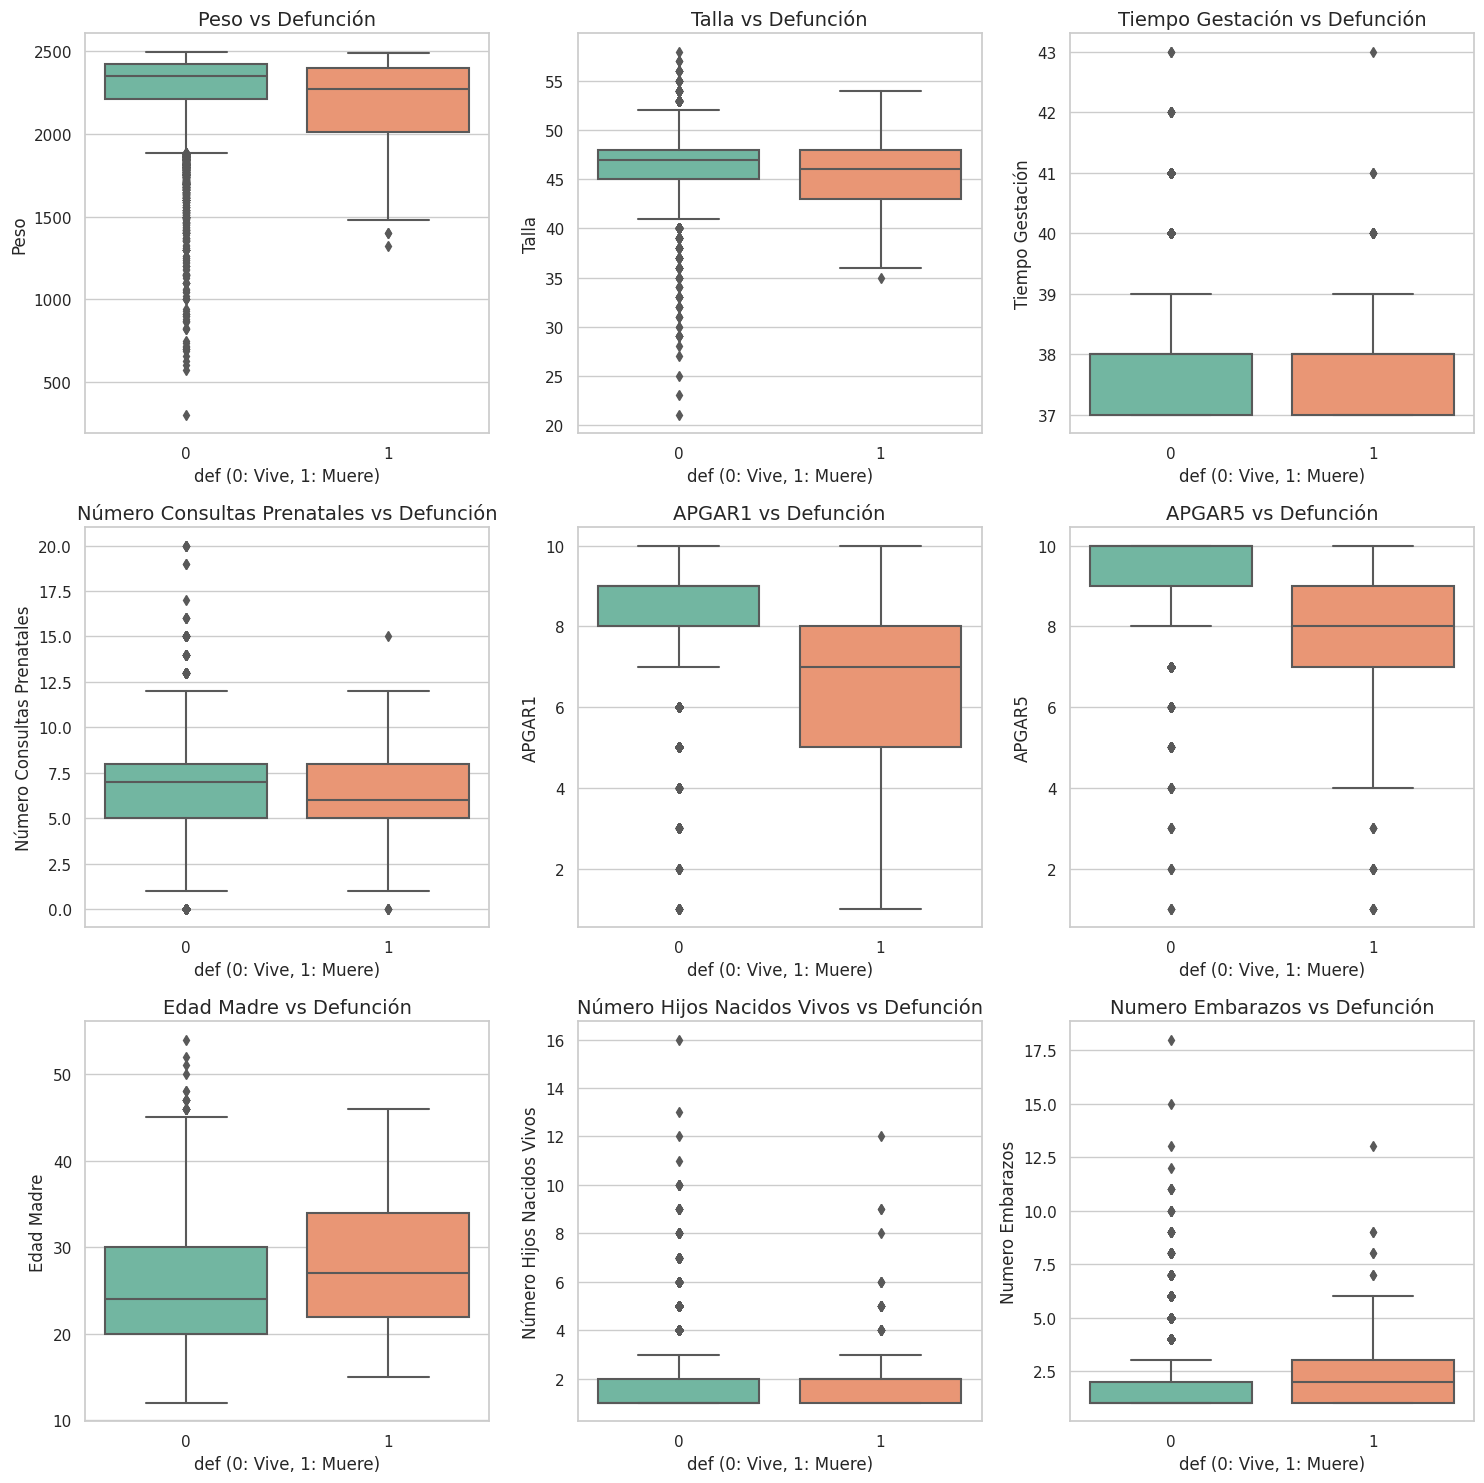

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asegúrate de que 'def' está en df_numeric para el gráfico
df_numeric['def'] = df_desc['def']

# Lista de columnas numéricas
columnas_numericas = df_numeric.columns.drop('def')

# Configurar el estilo de Seaborn para un look más profesional
sns.set(style="whitegrid")

# Configurar tamaño del gráfico
plt.figure(figsize=(15, 15))

# Crear un boxplot para cada columna numérica
for i, columna in enumerate(columnas_numericas, 1):
    plt.subplot(3, 3, i)  # Ajustar según la cantidad de columnas numéricas
    sns.boxplot(x='def', y=columna, data=df_numeric, palette="Set2")

    # Ajustar título y etiquetas para cada gráfico
    plt.title(f'{columna} vs Defunción', fontsize=14)
    plt.xlabel('def (0: Vive, 1: Muere)', fontsize=12)
    plt.ylabel(columna, fontsize=12)

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()
plt.show()


In [26]:
# Columnas para las cuales quieres calcular la mediana
columnas = ['Tiempo Gestación', 'Talla', 'Número Consultas Prenatales', 'APGAR1', 'APGAR5', 'Numero Embarazos']

# Valores únicos en la columna 'def' para los cuales calcularás las medianas
valores_def = df_numeric['def'].unique()

# Lista para almacenar los resultados
resultados_desc = []

# Calcular la mediana para cada combinación de columna y valor de 'def'
for columna in columnas:
    for valor in valores_def:
        mediana = df_numeric.loc[df_numeric['def'] == valor, columna].median()
        min =  df_numeric.loc[df_numeric['def'] == valor, columna].min()
        max = df_numeric.loc[df_numeric['def'] == valor, columna].max()
        desv = df_numeric.loc[df_numeric['def'] == valor, columna].std()

        resultados_desc.append({'Columna': columna, 'Valor_def': valor, 'Min': min, 'Max': max, 'Mediana': mediana, 'Desv.':desv})

# Crear un DataFrame a partir de los resultados
df_desc2 = pd.DataFrame(resultados_desc)

# Mostrar el DataFrame
print(df_desc2)


                        Columna  Valor_def   Min   Max  Mediana     Desv.
0              Tiempo Gestación          0  37.0  43.0     38.0  0.994228
1              Tiempo Gestación          1  37.0  43.0     38.0  1.039869
2                         Talla          0  21.0  58.0     47.0  2.435783
3                         Talla          1  35.0  54.0     46.0  3.202536
4   Número Consultas Prenatales          0   0.0  20.0      7.0  2.497709
5   Número Consultas Prenatales          1   0.0  15.0      6.0  2.459706
6                        APGAR1          0   1.0  10.0      9.0  0.969379
7                        APGAR1          1   1.0  10.0      7.0  2.489280
8                        APGAR5          0   1.0  10.0     10.0  0.719685
9                        APGAR5          1   1.0  10.0      8.0  2.519167
10             Numero Embarazos          0   1.0  18.0      1.0  1.212554
11             Numero Embarazos          1   1.0  13.0      2.0  1.733063


### GRAFICOS DE DATOS NUMÉRICOS: CRUCE CON MORTALIDAD

### Imputación de datos faltantes: CATEGORICOS.

In [ ]:
df_categoric = df_desc.select_dtypes(include=[object, 'category'])

In [ ]:
df_categoric.describe()

,Area Nacimiento,Sitio Parto,Sexo,Fecha Nacimiento,Parto Atendido Por,Tipo Parto,Multiplicidad Embarazo,Grupo Sanguineo,Factor RH,Pertenencia Étnica,Numero Documento Madre,Estado Conyugal Madre,Último Año Estudios Madre,Municipio Residencia,Área Residencia,Fecha Nacimiento Anterior Hijo,Régimen Seguridad Social,Año,def
count,19407,19407,19407,19407,19407,19407,19407,19245,19244,19407,1.912900e+04,19407,19407,19407,19407,10289,19406,19407,19407
unique,3,3,3,4263,6,4,3,5,3,6,1.633100e+04,7,14,53,4,6321,5,12,2
top,CABECERA MUNICIPAL,INSTITUCIÓN DE SALUD,FEMENINO,2011-09-09,MÉDICO,ESPONTÁNEO,SIMPLE,O,POSITIVO,NINGUNO DE LOS ANTERIORES,1.151944e+09,NO ESTABA CASADO(A) Y LLEVABA DOS AÑOS O MÁS V...,MEDIA ACADÉMICA O CLÁSICA,CALI,CABECERA MUNICIPAL,1900-01-01 00:00:00,SUBSIDIADO,2012,0
freq,19277,19197,11409,16,19193,10787,17794,12086,18124,15123,5.000000e+00,8943,7464,8995,16518,2067,9149,2135,19128


In [ ]:
import pandas as pd

# Asumiendo que df_categoric es tu DataFrame
# Crear un diccionario para almacenar los conteos
conteos_categorias = {}

# Iterar a través de cada columna categórica
for columna in df_categoric.columns:
    conteos_categorias[columna] = df_categoric[columna].value_counts()

# Opcional: Convertir el diccionario a un DataFrame para una mejor visualización

In [ ]:
for i in range(0,len(list(conteos_categorias))) :
  print(list(conteos_categorias.values())[i],'\n')

CABECERA MUNICIPAL                                      19277
RURAL DISPERSO                                             90
CENTRO POBLADO (INSPECCIÓN, CORREGIMIENTO O CASERÍO)       40
Name: Area Nacimiento, dtype: int64 

INSTITUCIÓN DE SALUD    19197
EL DOMICILIO              174
OTRO SITIO                 36
Name: Sitio Parto, dtype: int64 

FEMENINO         11409
MASCULINO         7993
INDETERMINADO        5
Name: Sexo, dtype: int64 

2011-09-09    16
2011-09-14    16
2013-02-23    15
2021-08-28    15
2012-08-25    15
              ..
2015-03-13     1
2019-02-02     1
2015-03-16     1
2019-01-27     1
2011-01-01     1
Name: Fecha Nacimiento, Length: 4263, dtype: int64 

MÉDICO                    19193
OTRA PERSONA                 84
PARTERA                      84
PROMOTOR(A) DE SALUD         24
ENFERMERO(A)                 18
AUXILIAR DE ENFERMERÍA        4
Name: Parto Atendido Por, dtype: int64 

ESPONTÁNEO       10787
CESÁREA           8601
INSTRUMENTADO       10
IGNORADO      

No se realiza proceso de imputación puesto que no faltan datos reelevantes dentro del análisis. Pero si se realiza el proceso de recategorización de los datos, más adelante.

## CREACIÓN DE CARACTERISTICAS: Periodo intergenésico.

La fecha de nacimiento, la fecha de parto anterior y el número de semanas gestacionales se extraen para poder calcular la variable que categoriza el periodo intergenesico:
Definido como el tiempo entre la fecha de nacimiento de un hijo y la fecha de fecundación de un próximo hijo. Definido como:

---

`años_intergenesicos = años transcurridos entre((fecha_nacimiento - semanas_gestación) - fecha de nacimiento del hijo anterior).`

---

In [ ]:
df_desc['Fecha Nacimiento Anterior Hijo'].value_counts()

1900-01-01 00:00:00    2067
2010-05-26               10
2009-06-03                7
2012-11-08                7
2005-06-03                7
                       ... 
2014-11-05                1
2014-11-05 00:00:00       1
2008-01-01                1
2013-01-23 00:00:00       1
2005-12-27                1
Name: Fecha Nacimiento Anterior Hijo, Length: 6321, dtype: int64

In [ ]:
df_desc['Fecha Nacimiento'] = pd.to_datetime(df_desc['Fecha Nacimiento'])
df_desc['Fecha Nacimiento Anterior Hijo'] = pd.to_datetime(df_desc['Fecha Nacimiento Anterior Hijo'], errors='coerce')

<ipython-input-26-f70ad0efb29e>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_desc['Fecha Nacimiento Anterior Hijo'] = pd.to_datetime(df_desc['Fecha Nacimiento Anterior Hijo'], errors='coerce')


In [ ]:
nat_count = df_desc['Fecha Nacimiento Anterior Hijo'].isna().sum()
print("Número de NaT:", nat_count)

Número de NaT: 9119


In [ ]:
# Asegúrate de que 'fec_h_ant' ya esté convertida a datetime
atypical_years_count = df_desc['Fecha Nacimiento Anterior Hijo'][(df_desc['Fecha Nacimiento Anterior Hijo'].dt.year > 2023) |
                                                                    (df_desc['Fecha Nacimiento Anterior Hijo'].dt.year < 1950)].shape[0]
print("Número de fechas con años atípicos:", atypical_years_count)

Número de fechas con años atípicos: 2067


In [ ]:
9119 + 2067

11186

In [ ]:
(df_desc['Número Hijos Nacidos Vivos'] == 1).value_counts()

True     11094
False     8313
Name: Número Hijos Nacidos Vivos, dtype: int64

In [ ]:
11186 - 11094

92

La lógica anterior se extraen las fechas no lógicas o vacías en la columna Fecha de nac del hijo anterior. las cuales deberían tener valores no lógicos o vacíos en los embarazos primerizos. es decir cuando El número de hijos nacidos vivos es igual a 1. al hacer la diferencia dan 92 que a pesar de no ser primerizas igual tienen la fecha de nacimiento del anterior hijo vacía.

Para el periodo intergenésico se calcula la siguiente función: que se aplicará para todas las filas en el dataset relacionando cada condicional y operación, se tienen los escenarios para las primerizas. para las 92 no encontradas o perdidas y para el resto que se basa en calculo usando la fecha de nacimiento las semanas de gestación y la fecha de nacimiento del hijo anterior.

In [ ]:
def calcular_periodo_intergenesico(row):
    # Primerizas o embarazo múltiple doble
    if (row['Número Hijos Nacidos Vivos'] == 1) | ((row['Número Hijos Nacidos Vivos'] == 2) & (row['Multiplicidad Embarazo'] == 'DOBLE')):
        return 'primeriza'
    # Datos perdidos o años anteriores a 1950
    elif pd.isna(row['Fecha Nacimiento Anterior Hijo']) or row['Fecha Nacimiento Anterior Hijo'].year < 1950:
        return 'perdido'
    # Fechas de nacimiento iguales (deberían ser diferentes para calcular un período intergenésico)
    elif row['Fecha Nacimiento Anterior Hijo'] == row['Fecha Nacimiento']:
        return 'perdido'
    # Faltaba una condición aquí, se agregó una que chequea si la diferencia es menor a un año
    elif (row['Fecha Nacimiento'] - row['Fecha Nacimiento Anterior Hijo']).days < 365.25:
        return 'menos de un año'
    else:
        fecha_inicio = row['Fecha Nacimiento'] - pd.to_timedelta(row['Tiempo Gestación'], unit='W')

        # Calcular el período intergenésico
        periodo_intergenesico = (fecha_inicio - row['Fecha Nacimiento Anterior Hijo']).days / 365.25

        # Categorizar según el período intergenésico
        if periodo_intergenesico < 1:
            return 'menos de un año'
        elif 1 <= periodo_intergenesico <= 2:
            return 'un año a dos años'
        else:
            return 'más de dos años'

In [ ]:
df_desc['periodo_inter'] = df_desc.apply(calcular_periodo_intergenesico, axis=1)

In [ ]:
df_desc['periodo_inter'].value_counts()

primeriza            11760
más de dos años       5697
un año a dos años     1064
menos de un año        552
perdido                334
Name: periodo_inter, dtype: int64

Antes de eliminar algunas variables, las guardamos en vectores que permitan tenerlas a la mano. El número de documento, la fecha de nacimiento y la fecha de nacimiento del hijo anterior. Es importante reconocer que en este punto el orden de las filas del dataframe se mantendrá a lo largo del análisis para que mantengan la posición y poder ser verificables.

In [ ]:
df_desc = df_desc.drop(['Fecha Nacimiento','Fecha Nacimiento Anterior Hijo'], axis=1)

## RECODIFICACIÓN DE DATOS CATEGORICOS:

In [ ]:
df_categoric = df_desc.select_dtypes(include=[object, 'category'])

In [ ]:
# Crear un diccionario para almacenar los conteos
conteos_categorias = {}

# Iterar a través de cada columna categórica
for columna in df_categoric.columns:
    conteos_categorias[columna] = df_categoric[columna].value_counts()

# Opcional: Convertir el diccionario a un DataFrame para una mejor visualización

In [ ]:
# Crear un diccionario para mapear los nombres actuales a los nuevos nombres
recategorizacion = {
    "CABECERA MUNICIPAL": "CABECERA",
    "RURAL DISPERSO": "RURAL",
    "CENTRO POBLADO (INSPECCIÓN, CORREGIMIENTO O CASERÍO)": "CENTRO POBLADO"
}

# Suponiendo que tu DataFrame se llama df y que 'Area Nacimiento' es el nombre de la columna
df_desc['Area Nacimiento'] = df_desc['Area Nacimiento'].map(recategorizacion)


In [ ]:
# Crear un diccionario para mapear los nombres actuales a los nuevos nombres
nuevas_categorias_sitio_parto = {
    "INSTITUCIÓN DE SALUD": "INSTITUCIÓN",
    "EL DOMICILIO": "DOMICILIO",
    "OTRO SITIO": "OTRO"
}

# Suponiendo que tu DataFrame se llama df y que 'Sitio Parto' es el nombre de la columna
df_desc['Sitio Parto'] = df_desc['Sitio Parto'].map(nuevas_categorias_sitio_parto)

In [ ]:
import numpy as np

# Calcular las proporciones de 'FEMENINO' y 'MASCULINO'
total = df_desc[df_desc['Sexo']!= 'INDETERMINADO']['Sexo'].value_counts().sum()
prop_femenino = df_desc[df_desc['Sexo']!= 'INDETERMINADO']['Sexo'].value_counts()['FEMENINO'] / total
prop_masculino = df_desc[df_desc['Sexo']!= 'INDETERMINADO']['Sexo'].value_counts()['MASCULINO'] / total

# Definir la función para la imputación
def imputar_sexo_aleatorio(sexo):
    if sexo == 'INDETERMINADO':
        # Asignar 'FEMENINO' o 'MASCULINO' basado en la distribución de probabilidad
        return np.random.choice(['FEMENINO', 'MASCULINO'], p=[prop_femenino, prop_masculino])
    else:
        return sexo

# Aplicar la función al DataFrame
df_desc['Sexo'] = df_desc['Sexo'].apply(imputar_sexo_aleatorio)


In [ ]:
# Definir la función para recategorizar los valores
def recategorizar_atencion(row):
    if row == 'MÉDICO':
        return 'MÉDICO'
    else:
        return 'OTRA PERSONA'

# Aplicar la función al DataFrame
df_desc['Parto Atendido Por'] = df_desc['Parto Atendido Por'].apply(recategorizar_atencion)


In [ ]:
# Definir la función para recategorizar los valores
def recategorizar_tipo(row):
    if row == 'SIMPLE':
        return 'SIMPLE'
    else:
        return 'MULTIPLE'

# Aplicar la función al DataFrame
df_desc['Multiplicidad Embarazo'] = df_desc['Multiplicidad Embarazo'].apply(recategorizar_tipo)


In [ ]:
# Crear un diccionario para mapear los nombres actuales a los nuevos nombres
recategorizacion_etnia = {
    "NINGUNO DE LOS ANTERIORES": "NINGUNO",
    "NEGRO(A), MULATO(A), AFRO COLOMBIANO(A) O AFRO DESCENDIENTE": "AFRO",
    "INDÍGENA": "INDÍGENA",
    "PALENQUERO DE SAN BASILIO": "PALENQUERO",
    "ROM (GITANO)": "ROM",
    "RAIZAL DEL ARCHIPIÉLAGO DE SAN ANDRÉS Y PROVIDENCIA": "RAIZAL"
}

# Suponiendo que tu DataFrame se llama df y que 'Pertenencia Étnica' es el nombre de la columna
df_desc['Pertenencia Étnica'] = df_desc['Pertenencia Étnica'].map(recategorizacion_etnia)

In [ ]:
# Crear un diccionario para mapear los nombres actuales a los nuevos nombres
recategorizacion_estado_conyugal = {
    "NO ESTABA CASADO(A) Y LLEVABA DOS AÑOS O MÁS VIVIENDO CON SU PAREJA": "UNIÓN ESTABLE +2 AÑOS",
    "NO ESTABA CASADO(A) Y LLEVABA MENOS DE DOS AÑOS VIVIENDO CON SU PAREJA": "UNIÓN ESTABLE -2 AÑOS",
    "ESTABA SOLTERO(A)": "SOLTERO(A)",
    "ESTABA CASADO(A)": "CASADO(A)",
    "SIN INFORMACIÓN": "SIN INFORMACIÓN",
    "ESTABA SEPARADO(A), DIVORCIADO(A)": "SEPARADO(A)/DIVORCIADO(A)",
    "ESTABA VIUDO(A)": "VIUDO(A)"
}

# Suponiendo que tu DataFrame se llama df y que 'Estado Conyugal Madre' es el nombre de la columna
df_desc['Estado Conyugal Madre'] = df_desc['Estado Conyugal Madre'].map(recategorizacion_estado_conyugal)


In [ ]:
# Crear un diccionario para mapear los nombres actuales a las nuevas categorías
recategorizacion_educacion = {
    "BÁSICA PRIMARIA": "ED BÁSICA",
    "BÁSICA SECUNDARIA": "ED BÁSICA",
    "MEDIA ACADÉMICA O CLÁSICA": "ED BÁSICA",
    "MEDIA TÉCNICA": "ED BÁSICA",
    "PREESCOLAR": "ED BÁSICA",
    "NORMALISTA": "ED BÁSICA",
    "PROFESIONAL": "ED SUPERIOR",
    "TÉCNICA PROFESIONAL": "ED SUPERIOR",
    "TECNOLÓGICA": "ED SUPERIOR",
    "ESPECIALIZACIÓN": "ED SUPERIOR",
    "MAESTRÍA": "ED MAESTRANTE",
    "DOCTORADO": "ED DOCTORAL",
    "NINGUNO": "SIN EDUCACIÓN",
    "SIN INFORMACIÓN": "SIN INFORMACIÓN"
}

# Suponiendo que tu DataFrame se llama df y que 'Último Año Estudios Madre' es el nombre de la columna
df_desc['Último Año Estudios Madre'] = df_desc['Último Año Estudios Madre'].map(recategorizacion_educacion)

In [ ]:
# Definir la función para recategorizar los municipios
def recategorizar_municipio(municipio):
    if municipio == 'CALI':
        return 'CALI'
    elif municipio == 'BUENAVENTURA':
        return 'BUENAVENTURA'
    else:
        return 'OTROS'

# Aplicar la función al DataFrame
df_desc['Municipio Residencia'] = df_desc['Municipio Residencia'].apply(recategorizar_municipio)

In [ ]:
# Crear un diccionario para mapear los nombres actuales a los nuevos nombres
recategorizacion_area_nacimiento = {
    "CABECERA MUNICIPAL": "CABECERA",
    "RURAL DISPERSO": "RURAL",
    "CENTRO POBLADO (INSPECCIÓN, CORREGIMIENTO O CASERÍO)": "CENTRO POBLADO",
    "CENTRO POBLADO (INSPECCIÓN,  CORREGIMIENTO O CASERÍO)": "CENTRO POBLADO"  # Nota el espacio adicional en la categoría original
}

# Suponiendo que tu DataFrame se llama df y que 'Area Nacimiento' es el nombre de la columna
df_desc['Área Residencia'] = df_desc['Área Residencia'].map(recategorizacion_area_nacimiento)

In [ ]:

# Identificar las columnas categóricas
columnas_categoricas = df_desc.select_dtypes(include=['category', 'object']).columns

# Imprimir los valores únicos de cada columna categórica
for columna in columnas_categoricas:
    print(f"Valores únicos en '{columna}': {df_desc[columna].unique()}")


Valores únicos en 'Area Nacimiento': ['CABECERA' 'CENTRO POBLADO' 'RURAL']
Valores únicos en 'Sitio Parto': ['INSTITUCIÓN' 'OTRO' 'DOMICILIO']
Valores únicos en 'Sexo': ['MASCULINO' 'FEMENINO']
Valores únicos en 'Parto Atendido Por': ['MÉDICO' 'OTRA PERSONA']
Valores únicos en 'Tipo Parto': ['CESÁREA' 'ESPONTÁNEO' 'INSTRUMENTADO' 'IGNORADO']
Valores únicos en 'Multiplicidad Embarazo': ['SIMPLE' 'MULTIPLE']
Valores únicos en 'Grupo Sanguineo': ['O' 'A' 'B' nan 'SIN INFORMACIÓN' 'AB']
Valores únicos en 'Factor RH': ['POSITIVO' 'NEGATIVO' nan 'SIN INFORMACIÓN']
Valores únicos en 'Pertenencia Étnica': ['AFRO' 'NINGUNO' 'INDÍGENA' 'ROM' 'RAIZAL' 'PALENQUERO']
Valores únicos en 'Numero Documento Madre': [3.158925e+07, 1.112775e+09, 6.672946e+07, 1.130647e+09, 9.312192e+10, ..., 1.114824e+09, 1.006434e+09, 6.703995e+07, 1.114880e+09, 1.113676e+09]
Length: 16332
Categories (16331, float64): [646.0, 1224.0, 113061.0, 243513.0, ..., 9.593737e+14, 9.596087e+14,
                              9.631

<ipython-input-48-354da00d7fb3>:6: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  print(f"Valores únicos en '{columna}': {df_desc[columna].unique()}")


In [ ]:
variables_categoricas = df_desc.select_dtypes(include=['object','category'])

In [ ]:
variables_categoricas = variables_categoricas.drop(['Numero Documento Madre','Año'], axis=1).copy()

In [ ]:
variables_categoricas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19407 entries, 0 to 19406
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Area Nacimiento            19407 non-null  object  
 1   Sitio Parto                19407 non-null  object  
 2   Sexo                       19407 non-null  object  
 3   Parto Atendido Por         19407 non-null  object  
 4   Tipo Parto                 19407 non-null  object  
 5   Multiplicidad Embarazo     19407 non-null  object  
 6   Grupo Sanguineo            19245 non-null  object  
 7   Factor RH                  19244 non-null  object  
 8   Pertenencia Étnica         19407 non-null  object  
 9   Estado Conyugal Madre      19407 non-null  object  
 10  Último Año Estudios Madre  19407 non-null  object  
 11  Municipio Residencia       19407 non-null  object  
 12  Área Residencia            19407 non-null  object  
 13  Régimen Seguridad Social   1940

In [ ]:
df_desc.to_csv("/content/drive/My Drive/Datos_BPN2023/datos_generados_V2/df_para_modelo.csv", sep = ";", index = False)